In [1]:
# ==========================================================
# FINAL, COMPLETE TRAINING SCRIPT FOR ZONAL-MEAN (2D) OUTPUT
# ==========================================================

"UPDATED KERNEL HIDDEN SIZE and updated Learning Rate"
import os
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score
from keras.models import Model
from keras.layers import Dense, PReLU, Dropout, Conv2D, Flatten, MaxPooling2D, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
import xarray as xr
import scipy.io as sio

# --- 1. Configuration ---
# Ensure this section points to the correct files for the model you are training (e.g., CESM1 or CESM2)
# Using CESM2 paths as an example:
path_input = "/ocean/projects/ees250004p/ezhu3/data/CESM1/control/input.B1850C5CN.TS.ANN.0400-2200.new.nc"
In_name = "TS" 
path_output = "/ocean/projects/ees250004p/ezhu3/data/CESM1/control/output.B1850C5CN.TOA.zmean.ANN.0400-2200.new.nc"
Out_name = "TOA_anom" 
data_dir_out = '/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_changedLRandKS'

# Hyperparameters from your script
kernels = [32, 32]
kernel_acts = ["gelu", "gelu"]
hiddens = [128, 128]
activation_function_dense = ["PReLU", "PReLU"]
loss_function = 'mse'
reg_strength = 0
dropout_rate = 0.25
epoch_max = 25000
batch_size = 32
learning_rate = 0.001
num_folds = 5
NNrepeats = 1

2025-07-30 16:43:26.569027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-30 16:43:26.676393: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 16:43:26.710221: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import logging
from tensorflow.keras.callbacks import Callback

def create_NN_name():
    NN_name = 'CNN'
    activation_function_str = '_' + kernel_acts[0] + '+' + activation_function_dense[0]
    NN_structure_str = 'x'.join(map(str, kernels))
    reg_str = f'Reg{reg_strength}' + (f'Drop{dropout_rate}' if dropout_rate != 0 else '')
    batch_size_str = f'BS{batch_size}_'
    # This creates a long, descriptive name like "CNN_Neur32x32_BS32_..."
    return f"{NN_name}_Neur{NN_structure_str}_{batch_size_str}{num_folds}foldCV_{reg_str}{activation_function_str}"

NN_name = create_NN_name()
# The final output_dir will be something like .../trained_model_2D/NeuralNet/CNN_Neur32x32.../TOA_anom
output_dir = os.path.join(data_dir_out, 'NeuralNet', NN_name, "TOA_anom")
os.makedirs(output_dir, exist_ok=True)
print(f"✅ Models and logs will be saved in: {output_dir}")

# ==========================================================
# Logger and Custom Callback Configuration
# ==========================================================

# --- 1. Configure the Logger ---
# This sets up logging to save progress messages to 'logfile.log'
# and also print them to your screen.

print("--- Configuring Logger ---")
logger_name = 'logfile.log'
# Get a logger instance
logger = logging.getLogger(__name__)
# Clear existing handlers to avoid duplicate messages in notebooks
if (logger.hasHandlers()):
    logger.handlers.clear()
    
logger.setLevel(logging.INFO)

# Create handlers for file and console
file_handler = logging.FileHandler(os.path.join(output_dir, logger_name))
console_handler = logging.StreamHandler()
file_handler.setLevel(logging.INFO)
console_handler.setLevel(logging.INFO)

# Create a formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

logger.info(f"Logging configured. Output will be saved in: {output_dir}")


# --- 2. Define Custom Callback for Periodic Logging ---
# This creates the functionality to print the training loss every 10 epochs.

print("--- Defining Custom Keras Callbacks ---")
log_path = os.path.join(output_dir, 'training_logs.txt')

class PrintTrainingOnTextEvery10EpochsCallback(Callback):
    def __init__(self, log_path):
        super().__init__()
        self.log_path = log_path

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if epoch % 10 == 0:
            # Log to a text file
            with open(self.log_path, "a") as log_file:
                log_file.write(
                    f"Epoch: {epoch:>4} | "
                    f"Loss: {logs.get('loss', 0):.2e} | "
                    f"Validation loss: {logs.get('val_loss', 0):.2e}\n"
                )
            # Also print to the console
            print(
                f"Epoch {epoch:>4} - "
                f"Loss: {logs.get('loss', 0):.2e}, "
                f"Validation loss: {logs.get('val_loss', 0):.2e}"
            )

# Create the my_callbacks list that will be passed to model.fit()
my_callbacks = [
    PrintTrainingOnTextEvery10EpochsCallback(log_path=log_path),
]

print("✅ Logger and my_callbacks are now defined.")

2025-07-30 16:43:29,358 - Logging configured. Output will be saved in: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_changedLRandKS/NeuralNet/CNN_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PReLU/TOA_anom


✅ Models and logs will be saved in: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_changedLRandKS/NeuralNet/CNN_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PReLU/TOA_anom
--- Configuring Logger ---
--- Defining Custom Keras Callbacks ---
✅ Logger and my_callbacks are now defined.


In [3]:
# --- 2. Load and Prepare Data ---
print("--- Loading and Preparing Data ---")
# Load input data (TS maps)
ds_X = xr.open_dataset(path_input)
input_data = ds_X[In_name].values # Shape: (time, lat, lon)
lat = ds_X['lat'].values
lon = ds_X['lon'].values
num_latitudes = len(lat)

# Load NEW target output data (zonal-mean TOA)
ds_y = xr.open_dataset(path_output)
output_data = ds_y[Out_name].values # Shape: (time, lat)

# Check for consistent time dimension length
if input_data.shape[0] != output_data.shape[0]:
    raise ValueError(f"Time dimension mismatch! Input X has {input_data.shape[0]} samples, while Target Y has {output_data.shape[0]} samples.")

# The variables X and y will hold the raw data before normalization
X = input_data[:, :, :, np.newaxis] # Add channel dimension
y = output_data # Already in the correct [time, lat] shape

print(f"Input data shape (X): {X.shape}")
print(f"Output data shape (y): {y.shape}")

# --- 3. Normalization ---
print("--- Normalizing Data ---")
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
y_mean = np.mean(y, axis=0)
y_std = np.std(y, axis=0)

# These are the final, normalized arrays we will use for training
X_norm = (X - X_mean) / X_std
y_norm = (y - y_mean) / y_std
print("✅ Normalization complete.")

# Save normalization statistics
os.makedirs(data_dir_out, exist_ok=True)
sio.savemat(os.path.join(data_dir_out, 'Normalization_zonal.mat'),
            {'X_mean': X_mean, 'X_std': X_std, 'y_mean': y_mean, 'y_std': y_std})
print(f"Normalization data saved to {data_dir_out}")

--- Loading and Preparing Data ---
Input data shape (X): (1801, 192, 288, 1)
Output data shape (y): (1801, 192)
--- Normalizing Data ---
✅ Normalization complete.
Normalization data saved to /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_2D_changedLRandKS


In [4]:
# --- 4. Define your train_model function ---
# (You should have your 'train_model' function defined here as it was in your original script,
# making sure the final Dense layer is set to `Dense(num_latitudes, ...)` )
# For completeness, here is a compatible 'build_model' and 'train_model' structure:
def train_model(X_train, y_train, X_test, y_test, y_mean, y_std):
    inputs = tf.keras.Input(shape=(X_train.shape[1:]),)
    layers = inputs

    # Convolutional Layers
    for i, kernel_filters in enumerate(kernels): # Assuming kernels is a list of filter numbers
        layers = Conv2D(
            kernel_filters,
            (kernel_size, kernel_size), # Assuming kernel_size is defined
            strides=(stride, stride),     # Assuming stride is defined
            use_bias=True,
            padding="same",
            # NO 'activation' argument here if PReLU or another layer follows
            bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
        )(layers)

        # Apply PReLU (or other chosen activation)
        # Assuming kernel_acts[i] could be 'prelu', 'gelu', 'relu', etc.
        if kernel_acts[i].lower() == 'prelu':
            layers = PReLU(shared_axes=[1, 2],
                           alpha_initializer=tf.keras.initializers.Constant(0.25) # Common starting point
                          )(layers) # shared_axes for Conv2D with channels_last
        elif kernel_acts[i].lower() == 'gelu':
            layers = tf.keras.layers.Activation('gelu')(layers) # Using Activation layer for GeLU
        elif kernel_acts[i]: # For 'relu', 'elu', etc.
            layers = tf.keras.layers.Activation(kernel_acts[i])(layers)
        # If kernel_acts[i] is None or an empty string, no explicit activation layer added here.

        layers = MaxPooling2D((pool_size, pool_size))(layers) # Assuming pool_size is defined
    
    layers = Flatten()(layers)
    # Dense Layers
    for i, hidden_units in enumerate(hiddens): # Assuming hiddens is a list of unit numbers
        layers = Dense(
            hidden_units,
            use_bias=True,
            # NO 'activation' argument here
            bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
        )(layers)

        # Apply PReLU (or other chosen activation)
        # Assuming activation_function_dense[i] could be 'prelu', 'gelu', 'elu', etc.
        if activation_function_dense[i].lower() == 'prelu':
            layers = PReLU(alpha_initializer=tf.keras.initializers.Constant(0.25))(layers) # No shared_axes for Dense
        elif activation_function_dense[i].lower() == 'gelu':
            layers = tf.keras.layers.Activation('gelu')(layers)
        elif activation_function_dense[i]: # For 'elu', 'relu', etc.
            layers = tf.keras.layers.Activation(activation_function_dense[i])(layers)
        # If activation_function_dense[i] is None or an empty string, no explicit activation layer.

    num_latitudes = len(lat) # or lat.size
    output_layer = Dense(
        num_latitudes, # This is the change
        activation="linear",
        use_bias=True,
        bias_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
        kernel_initializer=tf.keras.initializers.RandomNormal(seed=rng_seed),
    )(layers)
    
    model = Model(inputs, output_layer)
    if fold_no + ens_no == 2: # Assuming these are defined in your script's scope
        model.summary()

    model.compile(loss=loss_function, optimizer=Adam(learning_rate=learning_rate)) # Assuming these are defined

    early_stopping = EarlyStopping(patience=10, monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1) # restore_best_weights=1 is True

    # Make sure my_callbacks is defined in this scope or passed as an argument
    history = model.fit(X_train, y_train, epochs=epoch_max, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=[early_stopping] + my_callbacks, verbose=0) # Added '+' for list concatenation

    skill = model.evaluate(X_test, y_test, verbose=0)
    pred = (model.predict(X_test) * y_std) + y_mean # Make sure y_std and y_mean are defined

    R2_val = []
    truth = (y_test * y_std) + y_mean
    for latind in range(truth.shape[1] if truth.ndim > 1 else 1): # Handle if y_test is 1D output
        y_lat = truth[:, latind] if truth.ndim > 1 else truth
        y_pred_lat = pred[:, latind] if pred.ndim > 1 else pred
        R2_val.append(r2_score(y_lat, y_pred_lat))
    
    model.save(os.path.join(output_dir,'model_fold'+str(fold_no)+'_ens'+str(ens_no)+'.h5'))
    
    return skill, history, pred, R2_val

In [5]:
def build_and_train_model(X_train, y_train, X_test, y_test):
    tf.keras.backend.clear_session()
    gc.collect()

    input_shape = X_train.shape[1:]
    output_shape = y_train.shape[1]
    
    # --- Define Model Architecture ---
    inputs = tf.keras.Input(shape=input_shape)
    # Define layers based on your hyperparameters
    x = Conv2D(kernels[0], 3, padding='same', activation=kernel_acts[0])(inputs)
    x = MaxPooling2D(2)(x)
    x = Conv2D(kernels[1], 3, padding='same', activation=kernel_acts[1])(x)
    x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(hiddens[0])(x)
    x = PReLU()(x) # As per your activation_function_dense
    x = Dense(hiddens[1])(x)
    x = PReLU()(x) # As per your activation_function_dense
    outputs = Dense(output_shape, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=loss_function, optimizer=Adam(learning_rate=learning_rate))
    
    early_stopping = EarlyStopping(patience=50, monitor='val_loss', mode='min', restore_best_weights=True, verbose=1)
    
    history = model.fit(X_train, y_train, epochs=epoch_max, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=[early_stopping]+my_callbacks, verbose=0)
    
    # Un-normalize prediction for storage
    pred_normalized = model.predict(X_test)
    pred_unnormalized = pred_normalized * y_std + y_mean
    
    return model, history, pred_unnormalized

# --- 5. K-Fold Training Loop ---
kfold = KFold(n_splits=num_folds, shuffle=False)
fold_no = 1
trained_model_predictions = []
trained_model_histories = []

print("\n--- Starting K-Fold Training ---")
for trainind, testind in kfold.split(X_norm, y_norm):
    X_train, X_test = X_norm[trainind], X_norm[testind]
    y_train, y_test = y_norm[trainind], y_norm[testind]
    
    print(f"--- Training Model: Fold {fold_no} ---")
    model, history, fold_pred = build_and_train_model(X_train, y_train, X_test, y_test)
    
    trained_model_histories.append(history)
    trained_model_predictions.append(fold_pred)
    
    model_filename = f'model_fold{fold_no}_ens1.h5' # Assuming 1 ensemble
    model.save(os.path.join(data_dir_out, model_filename))
    print(f"Saved model for fold {fold_no}: {model_filename}")
    fold_no += 1

print("\n✅ Training with {num_folds}-fold cross-validation finished!")


--- Starting K-Fold Training ---
--- Training Model: Fold 1 ---


2025-07-30 16:43:30.508451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-30 16:43:30.936579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2025-07-30 16:43:32.400671: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


Epoch    0 - Loss: 8.63e-01, Validation loss: 7.67e-01
Epoch   10 - Loss: 1.07e-01, Validation loss: 5.06e-01
Epoch   20 - Loss: 5.76e-02, Validation loss: 4.89e-01
Epoch   30 - Loss: 4.21e-02, Validation loss: 4.89e-01
Epoch   40 - Loss: 3.58e-02, Validation loss: 4.82e-01
Epoch   50 - Loss: 3.09e-02, Validation loss: 4.83e-01
Epoch   60 - Loss: 2.83e-02, Validation loss: 4.85e-01
Epoch   70 - Loss: 2.51e-02, Validation loss: 4.84e-01
Epoch   80 - Loss: 2.41e-02, Validation loss: 4.80e-01
Epoch   90 - Loss: 2.17e-02, Validation loss: 4.78e-01
Epoch  100 - Loss: 2.05e-02, Validation loss: 4.79e-01
Epoch  110 - Loss: 2.01e-02, Validation loss: 4.84e-01
Restoring model weights from the end of the best epoch: 68.
Epoch 118: early stopping
12/12 [==============================] - 0s 9ms/step
Saved model for fold 1: model_fold1_ens1.h5
--- Training Model: Fold 2 ---
Epoch    0 - Loss: 8.65e-01, Validation loss: 7.10e-01
Epoch   10 - Loss: 1.26e-01, Validation loss: 4.91e-01
Epoch   20 - Los


--- Starting Post-Training Analysis ---
Shape of final truth data for analysis: (1801, 192)
Shape of final prediction data for analysis: (1801, 192)

    Calculating Overall Pattern Correlation...
✅ Overall Pattern Correlation (r) = 0.7330

    Calculating and plotting R-squared per latitude...


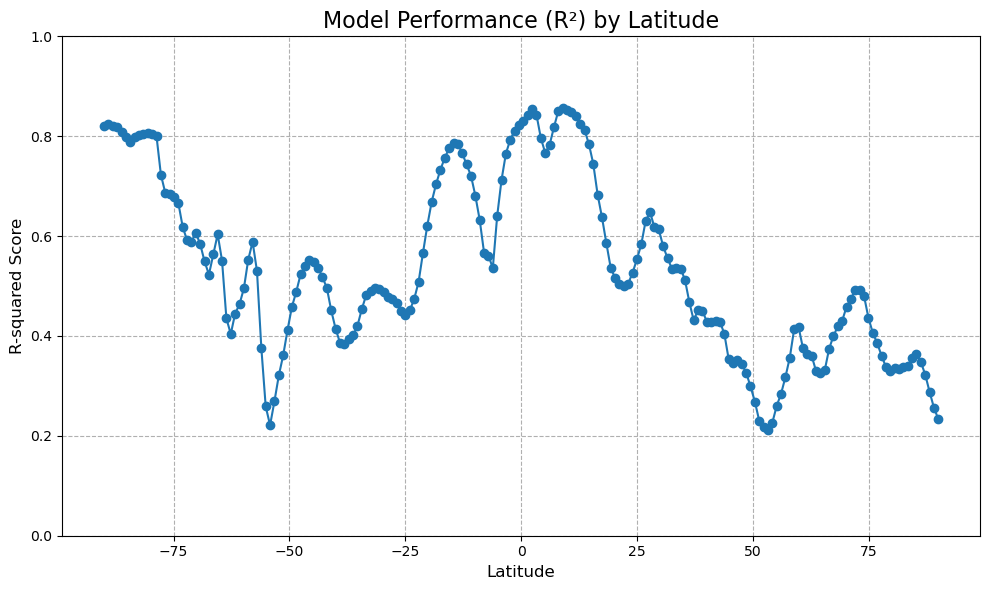


    Plotting Truth vs. Prediction as contour maps...


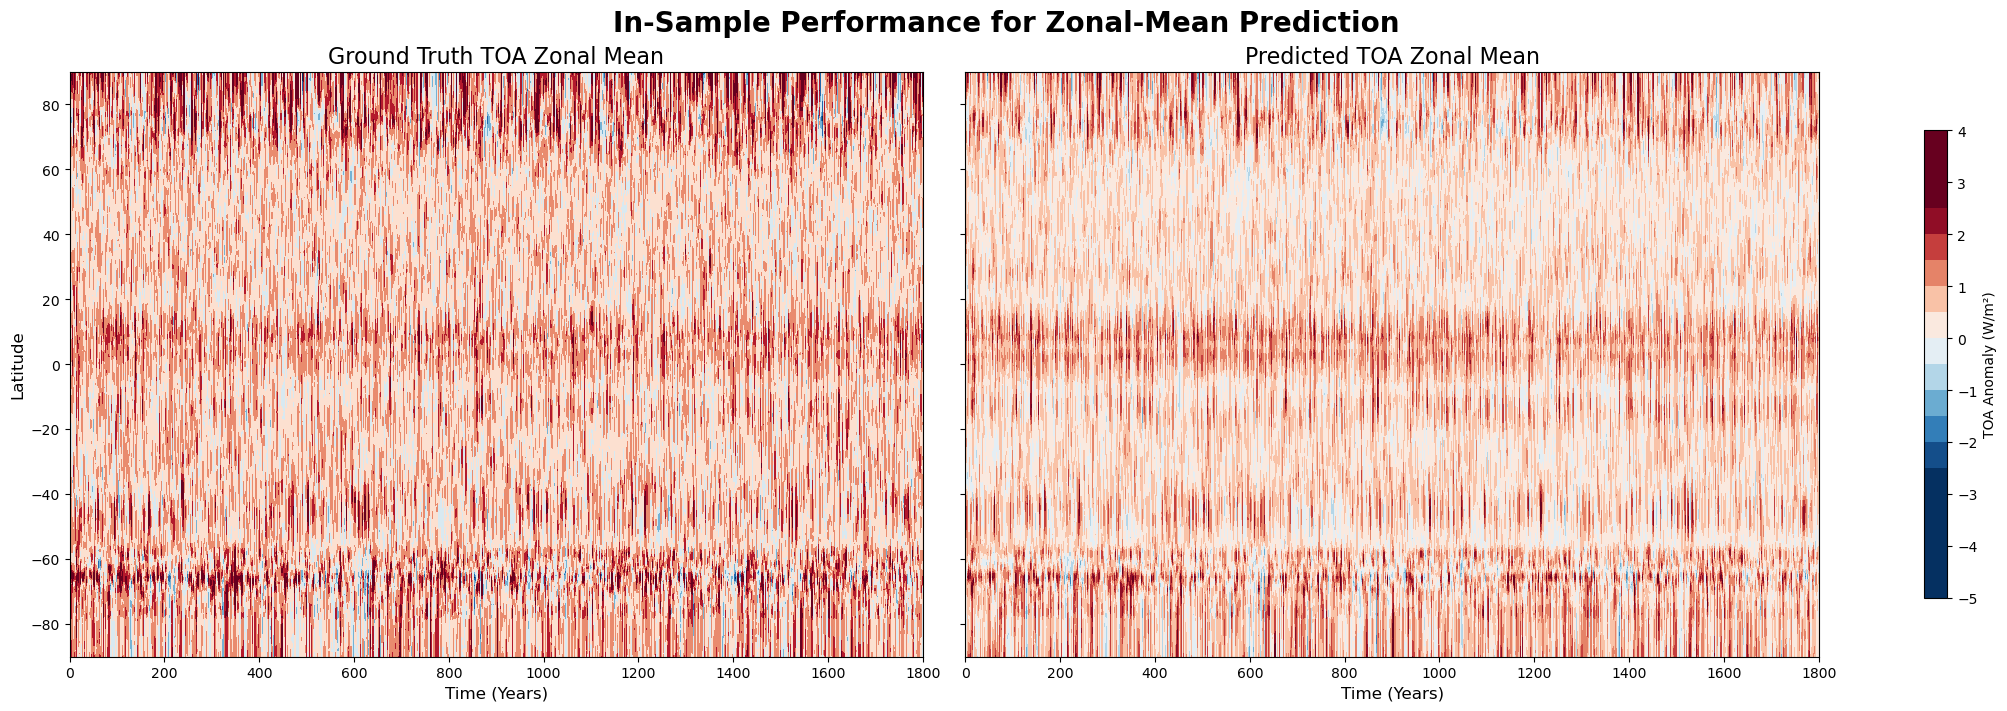

In [6]:
# --- 6. Post-Training Analysis and Visualization ---
print("\n--- Starting Post-Training Analysis ---")
Model_pred_zonal = np.concatenate(trained_model_predictions, axis=0)
y_truth_zonal = y # Use the un-normalized ground truth for comparison
print(f"Shape of final truth data for analysis: {y_truth_zonal.shape}")
print(f"Shape of final prediction data for analysis: {Model_pred_zonal.shape}")

# --- Calculate and Print Overall Pattern Correlation ---
print("\n    Calculating Overall Pattern Correlation...")
from scipy.stats import pearsonr # Ensure this is imported

# Flatten the 2D [time, lat] matrices into 1D vectors
truth_flat = y_truth_zonal.flatten()
pred_flat = Model_pred_zonal.flatten()

# Calculate Pearson correlation between the two flattened vectors
pattern_r, _ = pearsonr(truth_flat, pred_flat)

# Print the single pattern correlation value
print(f"✅ Overall Pattern Correlation (r) = {pattern_r:.4f}")

# --- 3. UPDATED: Plot R-squared as a Function of Latitude ---
print("\n    Calculating and plotting R-squared per latitude...")
from sklearn.metrics import r2_score # Ensure this is imported
r2_by_latitude = []
# Use num_latitudes, which should be defined from your data loading cell (e.g., len(lat))
for i in range(num_latitudes):
    # Calculate R-squared score for each latitude time series
    r2 = r2_score(y_truth_zonal[:, i], Model_pred_zonal[:, i])
    r2_by_latitude.append(r2)

# Plot R2 vs. Latitude
plt.figure(figsize=(10, 6))
plt.plot(lat, r2_by_latitude, marker='o', linestyle='-')
plt.title('Model Performance (R²) by Latitude', fontsize=16)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('R-squared Score', fontsize=12)
plt.grid(True, linestyle='--'); plt.ylim(0, 1)
plt.tight_layout()
# Use your 'output_dir' variable for saving
plt.savefig(os.path.join(output_dir, 'R2_vs_Latitude.png'), dpi=300)
plt.show()

# --- 4. Plot Truth vs. Prediction as a 2D Contour Map ---
print("\n    Plotting Truth vs. Prediction as contour maps...")
time_axis = np.arange(y_truth_zonal.shape[0])

# Use constrained_layout=True to automatically handle spacing
fig, axes = plt.subplots(1, 2, figsize=(20, 7), constrained_layout=True, sharey=True)

# Set the single color scale based on the ground truth
vmax = np.percentile(np.abs(y_truth_zonal), 98)
vmin = -vmax

# --- Plot Ground Truth ---
axes[0].set_title('Ground Truth TOA Zonal Mean', fontsize=16)
axes[0].contourf(time_axis, lat, y_truth_zonal.T, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0].set_xlabel('Time (Years)', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)

# --- Plot Model Prediction ---
axes[1].set_title('Predicted TOA Zonal Mean', fontsize=16)
# Capture the output of this plot for the color bar
cf = axes[1].contourf(time_axis, lat, Model_pred_zonal.T, levels=20, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('Time (Years)', fontsize=12)

# --- Create Color Bar and Title ---
# Create the color bar for the whole figure
fig.colorbar(cf, ax=axes.ravel().tolist(), shrink=0.8, label='TOA Anomaly (W/m²)')
# Set a main title for the figure
fig.suptitle('In-Sample Performance for Zonal-Mean Prediction', fontsize=20, weight='bold')

# Save and show the figure. No need for fig.tight_layout().
plt.savefig(os.path.join(output_dir, 'Truth_vs_Prediction_ZonalMean.png'), dpi=300)
plt.show()